<a href="https://colab.research.google.com/github/spradeep97/cv_foundations/blob/master/7_Image_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EECS 504 PS7: Image Translation


Pradeep Suresh, spradeep


# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [0]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import itertools

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torchsummary import summary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


PyTorch Version:  1.4.0
Torchvision Version:  0.5.0
Using the GPU!


# Problem 7.1 pix2pix
You will build pix2pix for image translation. Here is the website of pix2pix: https://phillipi.github.io/pix2pix/

Read the paper and github repo to understand how it implement.

In this question, you will need to:

1. Contruct dataloaders for train/test datasets
2. Build Generator and Discriminator
3. Train pix2pix and visualize the result during training
4. Plot the loss of generator/discriminator v.s. interation

## Step 0: Downloading the dataset.



In [0]:
# Download the CMP Facade Database
# Note: Restarting the runtime won't remove the downloaded dataset. You only need to re-download the zip file if you lose connection to colab. 
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz

# Unzip the download dataset .zip file to your local colab dir
!tar -xf facades.tar.gz

--2020-03-18 04:49:51--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.189.73
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.189.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz.2’

facades.tar.gz.2    100%[===================>]  28.77M  1.61MB/s    in 13s     

2020-03-18 04:50:05 (2.15 MB/s) - ‘facades.tar.gz.2’ saved [30168306/30168306]



## Step 1: Build dataloaders for train and test

In [0]:
def load_data(path, subfolder, transform, batch_size, shuffle=True):
    """
    Data loader.

    Inputs:
    - path: path of the data.
    - subfolder: subfolder of the data.
    - transform: data transformation.
    - batch_size: the size of the batch
    - shuffle: if true, shuffle the data

    Outputs:
    - torch Dataloader
    """
	
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== #
    #Hint: Use torch.utils.data.DataLoader
    dataset = torchvision.datasets.ImageFolder(path, transform=transform)
    dataset.class_to_idx[subfolder]
    data_loader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=shuffle)



    return data_loader
	  # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

In [0]:
# data_loader
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_loader = load_data('./facades', 'train', transform, 1, shuffle=True)
test_loader = load_data('./facades', 'val', transform, 10, shuffle=False)

#Sample Output used for visualization
test = test_loader.__iter__().__next__()[0]
img_size = test.size()[2]
fixed_y_ = test[:, :, :, 0:img_size]
fixed_x_ = test[:, :, :, img_size:]

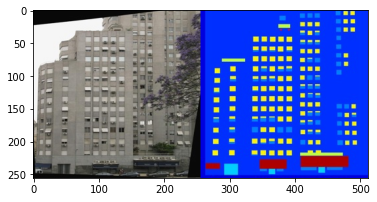

In [0]:
# plot sample image
example = train_loader.__iter__().__next__()[0][0].numpy().transpose((1, 2, 0))
example1 = train_loader.__iter__().__next__()[0]
# print(example.shape)
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
example = std * example + mean
plt.imshow(example)
plt.show()

## Step 2: Build Generator and Discriminator
Based on the paper, the architectures of network are as following:

**Generator architectures:**

U-net encoder:

C64-C128-C256-C512-C512-C512-C512-C512

U-net decoder:

CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128

After the last layer in the decoder, a convolution is applied to map to the number of output channels, followed by a Tanh
function. As an exception to the above notation, BatchNorm is not applied to the first C64 layer in the encoder.
All ReLUs in the encoder are leaky, with slope 0.2, while
ReLUs in the decoder are not leaky.

**Discriminator architectures**

The 70 × 70 discriminator architecture is:

C64-C128-C256-C512

After the last layer, a convolution is applied to map to
a 1-dimensional output, followed by a Sigmoid function.
As an exception to the above notation, BatchNorm is not
applied to the first C64 layer. All ReLUs are leaky, with
slope 0.2.

In [0]:
def normal_init(m, mean, std):
    """
    Helper function. Initialize parameter with given mean and std.
    """
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#
        # ============== YOUR CODE HERE ============== # 
        nn.init.normal_(m.weight.data, mean=mean, std=std)


        # ============== END OF CODE ================= # 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#

In [0]:
def get_module(in_channels, out_channels, kernel_size=4,stride=2, padding=True):
    if padding:
        module = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1),
                           nn.BatchNorm2d(out_channels),
                           nn.LeakyReLU(negative_slope=0.2))
    else:  
        module = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride),
                           nn.BatchNorm2d(out_channels),
                           nn.LeakyReLU(negative_slope=0.2))
    return module

def get_decode_module(in_channels, out_channels, kernel_size=4,stride=2,use_dropout=False):
    if use_dropout:
        module = nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=1),
                           nn.BatchNorm2d(out_channels),
                           nn.Dropout2d(),
                           nn.ReLU())
    else:
        module = nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=1),
                           nn.BatchNorm2d(out_channels),
                           nn.ReLU())
    return module

class generator(nn.Module):
    # initializers
    def __init__(self):
        super(generator, self).__init__()
		    #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#
        # ============== YOUR CODE HERE ============== #
        kernel_size = 4        
        self.add_module('enc0', nn.Sequential(nn.Conv2d(3, 64, kernel_size=kernel_size, stride=2,padding=1),
                                             nn.LeakyReLU(negative_slope=0.2)))
        self.add_module('enc1', get_module(64,128))
        self.add_module('enc2', get_module(128,256))
        self.add_module('enc3', get_module(256,512))
        self.add_module('enc4', get_module(512,512))
        self.add_module('enc5', get_module(512,512))
        self.add_module('enc6', get_module(512,512, padding=True))
        # self.add_module('enc7',get_module(512,512))
        self.add_module('enc7', nn.Sequential(nn.Conv2d(512, 512, kernel_size=kernel_size, stride=2, padding=1),
                                              nn.LeakyReLU(negative_slope=0.2)))
        self.add_module('dec1',get_decode_module(512,512,use_dropout=True))
        self.add_module('dec2',get_decode_module(1024,512,use_dropout=True))
        self.add_module('dec3',get_decode_module(1024,512,use_dropout=True))
        self.add_module('dec4',get_decode_module(1024,512))
        self.add_module('dec5',get_decode_module(1024,256))
        self.add_module('dec6',get_decode_module(512,128))
        self.add_module('dec7',get_decode_module(256,64))
        self.add_module('dec8',nn.ConvTranspose2d(128,3,4,2,padding=1))
        self.add_module('tanh',nn.Tanh())
		    # ============== END OF CODE ================= # 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, in_0):
		    #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#
        # ============== YOUR CODE HERE ============== # 
        in_1 = self._modules['enc0'](in_0)
        in_2 = self._modules['enc1'](in_1)
        in_3 = self._modules['enc2'](in_2)
        in_4 = self._modules['enc3'](in_3)
        in_5 = self._modules['enc4'](in_4)
        in_6 = self._modules['enc5'](in_5)
        in_7 = self._modules['enc6'](in_6)
        in_8 = self._modules['enc7'](in_7)

        dec_1 = self._modules['dec1'](in_8)
        dec_1 = torch.cat((dec_1, in_7), dim=1)
        dec_2 = self._modules['dec2'](dec_1)
        dec_2 = torch.cat((dec_2, in_6), dim=1)
        dec_3 = self._modules['dec3'](dec_2)
        dec_3 = torch.cat((dec_3,in_5),dim=1)
        dec_4 = self._modules['dec4'](dec_3)
        dec_4 = torch.cat((dec_4, in_4),dim=1)
        dec_5 = self._modules['dec5'](dec_4)
        dec_5 = torch.cat((dec_5,in_3),dim=1)
        dec_6 = self._modules['dec6'](dec_5)
        dec_6 = torch.cat((dec_6,in_2),dim=1)
        dec_7 = self._modules['dec7'](dec_6)
        dec_7 = torch.cat((dec_7,in_1),dim=1)
        dec_8 = self._modules['dec8'](dec_7)
        o = self._modules['tanh'](dec_8)
        # print(o.shape)

		    # ============== END OF CODE ================= # 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#

        return o

class discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator, self).__init__()
		    #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#
        # ============== YOUR CODE HERE ============== # 
        kernel_size = 4
        self.add_module('disc0',nn.Sequential(nn.Conv2d(6,64,kernel_size=kernel_size, stride=2, padding=1),
                                      nn.ReLU()))
        self.add_module('disc1',get_module(64,128))
        self.add_module('disc2',get_module(128,256))
        self.add_module('disc3',get_module(256,512))
        self.add_module('disc4',get_module(512,1))
        self.add_module('sigmoid',nn.Sigmoid())
		    # ============== END OF CODE ================= # 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, in_0):
		    #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#
        # ============== YOUR CODE HERE ============== # 
        in_1 = self._modules['disc0'](in_0)
        in_2 = self._modules['disc1'](in_1)
        in_3 = self._modules['disc2'](in_2)
        in_4 = self._modules['disc3'](in_3)
        in_5 = self._modules['disc4'](in_4)
        x = self._modules['sigmoid'](in_5)

		    # ============== END OF CODE ================= # 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#
        return x


## Step 3: Train

In this section, complete the function train. 
Then train two model: one with only L1 loss, the other with c=100.



In [0]:
# Helper function for showing result.
def process_image(img):
    return (img.cpu().data.numpy().transpose(1, 2, 0) + 1) / 2

def show_result(G, x_, y_, num_epoch):
    predict_images = G(x_)

    fig, ax = plt.subplots(x_.size()[0], 3, figsize=(10,30))

    for i in range(x_.size()[0]):
        ax[i, 0].get_xaxis().set_visible(False)
        ax[i, 0].get_yaxis().set_visible(False)
        ax[i, 1].get_xaxis().set_visible(False)
        ax[i, 1].get_yaxis().set_visible(False)
        ax[i, 2].get_xaxis().set_visible(False)
        ax[i, 2].get_yaxis().set_visible(False)
        ax[i, 0].cla()
        ax[i, 0].imshow(process_image(x_[i]))
        ax[i, 1].cla()
        ax[i, 1].imshow(process_image(predict_images[i]))
        ax[i, 2].cla()
        ax[i, 2].imshow(process_image(y_[i]))
    
    plt.tight_layout()
    label_epoch = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0, label_epoch, ha='center')
    label_input = 'Input'
    fig.text(0.18, 1, label_input, ha='center')
    label_output = 'Output'
    fig.text(0.5, 1, label_output, ha='center')
    label_truth = 'Ground truth'
    fig.text(0.81, 1, label_truth, ha='center')

    plt.show()

# Helper function for counting number of trainable parameters.
def count_params(model):
    '''
    Counts the number of trainable parameters in PyTorch.
    Args:
        model: PyTorch model.
    Returns:
        num_params: int, number of trainable parameters.
    '''
    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])
    return num_params

In [0]:
# Hint: you could use following loss to complete following function
BCE_loss = nn.BCELoss().cuda()
L1_loss = nn.L1Loss().cuda()

def train(G, D, num_epochs = 20, only_L1 = False):
    hist_D_losses = []
    hist_G_losses = []
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== # 
    # Adam optimizer
    G_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5,0.999))
    D_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5,0.999))
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== END OF CODE ============== #

    print('training start!')
    start_time = time.time()
    for epoch in range(num_epochs):
        print('Start training epoch %d' % (epoch + 1))
        D_losses = []
        G_losses = []
        epoch_start_time = time.time()
        num_iter = 0
        for x_, _ in train_loader:
            
            y_ = x_[:, :, :, 0:img_size]
            x_ = x_[:, :, :, img_size:]
                
            x_, y_ = Variable(x_.cuda()), Variable(y_.cuda())
            # train discriminator D
            #++++++++++++++++++++++++++++++++++++++++++++++#
            #++++++++++++++++++++++++++++++++++++++++++++++#
            # ============== YOUR CODE HERE ============== # 
            G_optimizer.zero_grad()
            D_optimizer.zero_grad()
            fake = G.forward(x_)
            fake_x = torch.cat((fake,x_),dim=1)
            y_x = torch.cat((y_,x_),dim=1)
            pred_real = D.forward(y_x)
            pred_fake = D.forward(fake_x.detach())
            ones = torch.ones_like(pred_real)
            zeros = torch.zeros_like(pred_fake)

            loss_D = 0.5 * (BCE_loss(pred_real, ones) + BCE_loss(pred_fake, zeros))
            loss_D.backward(retain_graph=True)
            D_optimizer.step()
            #++++++++++++++++++++++++++++++++++++++++++++++#
            #++++++++++++++++++++++++++++++++++++++++++++++#
             # ============== END OF CODE ============== #

            # D_losses.append(loss_D.cpu())
            # hist_D_losses.append(loss_D.cpu())
            # hist_D_losses.cpu()

            # train generator G
            #++++++++++++++++++++++++++++++++++++++++++++++#
            #++++++++++++++++++++++++++++++++++++++++++++++#
            # ============== YOUR CODE HERE ============== # 

            

            L1_l = L1_loss(y_,fake)
            GAN_l = BCE_loss(pred_fake, ones)
            if not only_L1:
                loss_G = GAN_l + 100 * L1_l
            else:
                loss_G = L1_l

            loss_G.backward()
            G_optimizer.step()
            #++++++++++++++++++++++++++++++++++++++++++++++#
            #++++++++++++++++++++++++++++++++++++++++++++++#
            # ============== END OF CODE ================= #

            # G_losses.append(loss_G.cpu())
            # # G_losses.cpu()
            # hist_G_losses.append(loss_G.cpu())
            # his_G_losses.cpu()
            num_iter += 1


        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        print('[%d/%d] - using time: %.2f' % ((epoch + 1), num_epochs, per_epoch_ptime))
        print('loss of discriminator D: %.3f' % (torch.mean(torch.FloatTensor(D_losses))))
        print('loss of generator G: %.3f' % (torch.mean(torch.FloatTensor(G_losses))))
        print('Sample Image:')
        show_result(G, Variable(fixed_x_.cuda(), volatile=True), fixed_y_, (epoch+1))

    end_time = time.time()
    total_ptime = end_time - start_time

    return hist_D_losses, hist_G_losses



In this part, train your model with c=100 with at leat 20 epoch.

In [0]:
# Define network
G_100 = generator()
D_100 = discriminator()
G_100.weight_init(mean=0.0, std=0.02)
D_100.weight_init(mean=0.0, std=0.02)
G_100.cuda()
D_100.cuda()
G_100.train()
D_100.train()

#Report the architectures of your network
print(G_100)
summary(G_100, (3,256,256))
print('Number of trainable parameters {}'.format(count_params(G_100)))

print(D_100)
summary(D_100, (6,256,256))
print('Number of trainable parameters {}'.format(count_params(D_100)))

generator(
  (enc0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (enc1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (enc2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (enc3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (enc4): Sequential(
    (0): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affin

In [0]:
#training
# TODO: change_num_epochs if you want
hist_D_100_losses, hist_G_100_losses = train(G_100, D_100, num_epochs = 20, only_L1 = False)

In this part, train your model with only L1 loss with at leat 10 epoch.

In [0]:
# Define network
G_L1 = generator()
D_L1 = discriminator()
G_L1.weight_init(mean=0.0, std=0.02)
D_L1.weight_init(mean=0.0, std=0.02)
G_L1.cuda()
D_L1.cuda()
G_L1.train()
D_L1.train()

#training
# TODO: change_num_epochs if you want
hist_D_L1_losses, hist_G_L1_losses = train(G_L1, D_L1, num_epochs = 10, only_L1 = True)

## Step 4: Visualization
In this section, plot the G/D loss history v.s. Iteration of model with c=100 in seperate plot.


In [0]:
# plot the G/D loss history v.s. Iteration in one plot
#++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++++++++++++++++++++++++++++++++#
# ============== YOUR CODE HERE ============== # 









#++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++++++++++++++++++++++++++++++++#
# =============== END OF CODE ================ #



In this section, plot the G/D loss history v.s. Iteration of model with only L1 loss in seperate plot.

In [0]:
# plot the G/D loss history v.s. Iteration in one plot
#++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++++++++++++++++++++++++++++++++#
# ============== YOUR CODE HERE ============== # 






#++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++++++++++++++++++++++++++++++++#
# =============== END OF CODE ================ #